In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('./data/Orders_Returns.csv')

In [3]:
df.head()

,Unnamed: 0,Row.ID,Order.ID,Order.Date,Ship.Date,Ship.Mode,Customer.ID,Customer.Name,Segment,Postal.Code,...,Quantity,Discount,Profit,Shipping.Cost,Order.Priority,Month,Year,Quarter,Returned,Region.y
0,1,40098,CA-2014-AB10015140-41954,2014-11-11,11/13/14,First Class,AB-100151402,Aaron Bergman,Consumer,73120.0,...,2,0.0,62.15,40.77,High,11,2014,4,NaN,NaN
1,2,26341,IN-2014-JR162107-41675,2014-02-05,2/7/14,Second Class,JR-162107,Justin Ritter,Corporate,NaN,...,9,0.1,-288.77,923.63,Critical,2,2014,1,NaN,NaN
2,3,25330,IN-2014-CR127307-41929,2014-10-17,10/18/14,First Class,CR-127307,Craig Reiter,Consumer,NaN,...,9,0.1,919.97,915.49,Medium,10,2014,4,NaN,NaN
3,4,13524,ES-2014-KM1637548-41667,2014-01-28,1/30/14,First Class,KM-1637548,Katherine Murray,Home Office,NaN,...,5,0.1,-96.54,910.16,Medium,1,2014,1,NaN,NaN
4,5,47221,SG-2014-RH9495111-41948,2014-11-05,11/6/14,Same Day,RH-9495111,Rick Hansen,Consumer,NaN,...,8,0.0,311.52,903.04,Critical,11,2014,4,NaN,NaN


In [6]:
#Make Returned a boolean 
def returned(order):
    if order == "Yes":
        return 1
    else:
        return 0
        

df.loc[:,'Returned'] = df.loc[:,'Returned'].apply(returned)

In [13]:
df.loc[:,'Ship.Date'] = df.loc[:,'Ship.Date'].apply(pd.to_datetime)
df.loc[:,'Order.Date'] = df.loc[:,'Order.Date'].apply(pd.to_datetime)

In [14]:
df.loc[:,'Process_Time'] = df['Ship.Date'] - df['Order.Date']

In [82]:
df['Process_Time'][0].days

int

In [50]:
product_returns = df.groupby('Product.ID')['Returned'].sum().reset_index('Product.ID')
product_returns = product_returns.rename(columns = {'Returned': 'Num_Returns'})

In [74]:
new_df = df.merge(product_returns, on = 'Product.ID')

First using a weighted RandomForest:



In [179]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [117]:
new_df = new_df.drop(['Product.Name'], axis = 1)

In [207]:
new_df.columns

Index(['Ship.Mode', 'Segment', 'City', 'State', 'Country', 'Region.x',
       'Market', 'Category', 'Sub.Category', 'Sales', 'Quantity', 'Discount',
       'Profit', 'Shipping.Cost', 'Order.Priority', 'Month', 'Year', 'Quarter',
       'Returned', 'Process_Time', 'Num_Returns'],
      dtype='object')

In [208]:
from collections import defaultdict
d = defaultdict(LabelEncoder)

# Encoding the variable
X = X.apply(lambda x: d[x.name].fit_transform(x))


In [211]:
X

,Ship.Mode,Segment,City,State,Country,Region.x,Market,Category,Sub.Category,Sales,Quantity,Discount,Profit,Shipping.Cost,Order.Priority,Month,Year,Quarter,Process_Time,Num_Returns
0,1,0,2368,754,156,5,4,2,13,10747,1,0,11124,9795,1,10,2,3,2,0
1,3,1,2510,787,156,9,4,2,13,14695,6,14,2140,8859,3,2,1,0,4,0
2,2,1,3532,709,6,12,1,0,5,19938,8,3,665,16450,0,1,2,0,2,2
3,1,1,585,832,94,3,3,0,5,17835,3,6,14774,16080,0,8,2,2,2,2
4,3,0,1715,540,90,14,1,0,5,19753,5,0,11963,15626,3,5,3,1,5,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51285,3,2,3503,707,156,9,4,1,14,3651,2,0,7796,2601,2,10,3,3,7,0
51286,3,2,2298,710,156,9,4,2,13,15484,2,0,13905,11875,1,11,3,3,4,0
51287,1,1,775,359,156,18,4,1,1,16267,7,0,13970,11788,1,2,3,0,3,0
51288,3,0,1916,196,156,22,4,2,11,14486,3,6,13503,8159,3,10,0,3,7,0


In [122]:
#Setup X and y
X = new_df.drop('Returned',axis = 1)
y = new_df['Returned']

In [180]:
X_train, X_test, y_train, y_test = train_test_split(
...     X, y, test_size=0.2, random_state=42)

In [216]:
rmf = RandomForestClassifier(class_weight='balanced', verbose= True)

In [217]:
rmf.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   10.3s finished


RandomForestClassifier(class_weight='balanced_subsample', verbose=True)

In [203]:
from sklearn.metrics import confusion_matrix

conf_mat_train = confusion_matrix(y_train, rmf.predict(X_train)) 
print(conf_mat_train)
conf_mat_test = confusion_matrix(y_test, rmf.predict(X_test)) 
print(conf_mat_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[[39246     0]
 [    0  1786]]
[[9822    2]
 [ 430    4]]


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


Really really bad model. Very overfit.

Will need a lot of hyperparameter tuning. 

<AxesSubplot:>

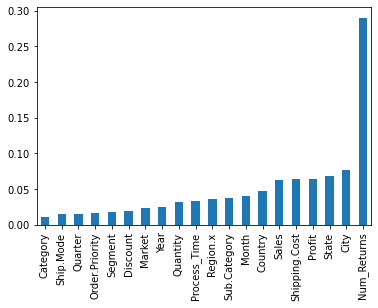

In [212]:
feature_importance = pd.Series(dict(zip(X.columns, rmf.feature_importances_)))
feature_importance.sort_values().plot.bar()

This is still interesting! 

Below trying an upsampling approach

In [219]:
from sklearn.utils import resample

d = defaultdict(LabelEncoder)

# Encoding the variable
new_df = new_df.apply(lambda x: d[x.name].fit_transform(x))

,Ship.Mode,Segment,City,State,Country,Region.x,Market,Category,Sub.Category,Sales,...,Discount,Profit,Shipping.Cost,Order.Priority,Month,Year,Quarter,Returned,Process_Time,Num_Returns
0,0,0,2368,754,156,5,4,2,13,10747,...,0,11124,9795,1,10,2,3,0,2,0
1,3,1,2510,787,156,9,4,2,13,14695,...,14,2140,8859,3,2,1,0,0,4,0
2,2,1,3532,709,6,12,1,0,5,19938,...,3,665,16450,0,1,2,0,0,2,2
3,0,1,585,832,94,3,3,0,5,17835,...,6,14774,16080,0,8,2,2,0,2,2
4,3,0,1715,540,90,14,1,0,5,19753,...,0,11963,15626,3,5,3,1,1,5,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51285,3,2,3503,707,156,9,4,1,14,3651,...,0,7796,2601,2,10,3,3,0,7,0
51286,3,2,2298,710,156,9,4,2,13,15484,...,0,13905,11875,1,11,3,3,0,4,0
51287,0,1,775,359,156,18,4,1,1,16267,...,0,13970,11788,1,2,3,0,0,3,0
51288,3,0,1916,196,156,22,4,2,11,14486,...,6,13503,8159,3,10,0,3,0,7,0


In [243]:
new_df_minority = resample(new_df[new_df.Returned == 0], replace= True, n_samples = 46794 )

new_df_upsampled = pd.concat((new_df_minority,new_df))

In [244]:
XU = new_df_upsampled.drop('Returned',axis = 1)
yU = new_df_upsampled['Returned']

XU_train, XU_test, yU_train, yU_test = train_test_split(XU, yU, test_size=0.2, random_state=42)

In [251]:
rmf = RandomForestClassifier(class_weight='balanced', verbose= True, max_depth= 10)

In [252]:
rmf.fit(XU_train,yU_train) 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    9.1s finished


RandomForestClassifier(class_weight='balanced', max_depth=10, verbose=True)

In [253]:
conf_mat_train = confusion_matrix(yU_train, rmf.predict(XU_train)) 
print(conf_mat_train)
conf_mat_test = confusion_matrix(yU_test, rmf.predict(XU_test)) 
print(conf_mat_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[[56008 20725]
 [   14  1720]]
[[13900  5231]
 [  122   364]]


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


Note I tuned the ma_depth a bit. It makes it a bit better. Really interesting though, we'd need to do a whole set of parameter tuning